# Inverse kinematics
This notebook considers the problem of inverse kinematics, ie solving at each control cycle of the robot a quadratic program from the derivatives (jacobian) of the current state. It introduces the basic function to compute the Jacobians of the robot, and how to use them to compute an inverse-kinematics control law. One of the key difficulties is to understand in which frames each quantities is computed (might be in the world frame, in the local frame attached to the end effector, in some arbitrary goal frame, etc), as we should never mixed quantities expressed in different frames without transporting them in the right frame. 


## Set up
We will use a Gepetto-viewer, and the linear algebra of NumPy.

In [1]:
import pinocchio as pin
import numpy as np
import time
from numpy.linalg import pinv,inv,norm,svd,eig
from utils.tiago_loader import loadTiago
import matplotlib.pylab as plt; plt.ion()
from utils.meshcat_viewer_wrapper import MeshcatVisualizer

We will use the Tiago robot (https://youtu.be/6BwRqwD066g). This mobile manipulator from PAL Robotics:
- has a mobile basis which can move in the plane (3 dof)
- a manipulator arm (7 dof)
- a head (2 dof) both mounted on a prismatic axis moving vertically (1 dof).

This makes 
- 3 dof for the basis
- 9 dof for the body.

It also has 2 extra joints tot figure the wheels, which are not very useful for this notebook. 

The wheels and the basis rotations are represented by the cos and sin of the angle.
The size of the configuration vector is then 18, while the velocity vector has dimension 15.

A load function is available to make it easy to load the robot.

In [2]:
robot = loadTiago()
viz = MeshcatVisualizer(robot)


You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/


In [3]:
# viz.viewer.jupyter_cell()

The configuration is represented by a vector of larger dimension, subject to constraints ( e.g. $cos^2+sin^2=1$).

It is not possible to randomly sample a configuration vector q, as these constraints should be respected.

Similarly, we should take care when integrating a velocity as summing a configuration q with a velocity v will not work (dimensions do not match).

Two functions in Pinocchio implements these functionnalities.

In [4]:
print(f"Velocity vector has {robot.model.nv} components")

Velocity vector has 15 components


In [5]:
np.random.seed(47)
q = pin.randomConfiguration(robot.model)
vq = np.random.rand(robot.model.nv)*2 - 1
DT = 1e-3
qnext = pin.integrate(robot.model, q, vq*DT)

A simple example moving the robot in the viewer following a constant (random) velocity is as follows.

In [ ]:
for t in range(1000):
    q = pin.integrate(robot.model,q,vq*DT)
    viz.display(q)
    time.sleep(DT/10)

The robot is mobile, hence the camera view in the viewer is not always centered. 

## Forward kinematics and Jacobian

- We recall first the basic method to compute the robot forward kinematics.

We will consider two frames of interest on the robot: 
- the first one, named <tool> is at the tip of the end-effector
- the second one, named <basis>, is on the front of the robot basis, 10 cm above the ground.

Both are represented in Gepetto-Viewer by a frame composed of three RGB arrows. 

![](figures/frames_of_interest.png)

In [6]:
IDX_TOOL = robot.model.getFrameId('frametool')
IDX_BASIS = robot.model.getFrameId('framebasis')

In [7]:
# for i in range(79):
#     print( robot.model.frames[i])
robot.model.frames[IDX_TOOL]
# I=quadratic moment of the mesh, m = mass

Frame name: frametool paired to (parent joint/ previous frame)(9/52)
with relative placement wrt parent joint:
  R =
1 0 0
0 1 0
0 0 1
  p =    0    0 0.08
containing inertia:
  m = 0
  c = 0 0 0
  I = 
0 0 0
0 0 0
0 0 0

`model.frame` contains a relative placement ($SE(3)$) to a parent frame which will be a joint frame (aka a principal frame). It also contains dynamic constant if it is a representing a link (aka associated to a mesh).

### Computing frame placement
The global placement of the frames are computed by the Pinocchio function framesForwardKinematics, whose results are stored in robot.data.oMf.


In [8]:
# First call the whole body algorithm
pin.framesForwardKinematics(robot.model,robot.data,q)
# Then get the position
oMtool = robot.data.oMf[IDX_TOOL]
oMbasis = robot.data.oMf[IDX_BASIS]

print("Tool placement:",oMtool) # instances of SE(3) object
print("Basis placement:",oMbasis)

Tool placement:   R =
 -0.855136   0.516048 -0.0493737
-0.0864268 -0.0480088   0.995101
  0.511149   0.855213  0.0856544
  p =  -0.964227 -0.0481239   0.414476

Basis placement:   R =
-0.999899 -0.014204         0
 0.014204 -0.999899         0
        0         0         1
  p = -0.623143 -0.447801      0.15



In [9]:
oMtool.translation

array([-0.96422703, -0.04812385,  0.41447554])

In [ ]:
new_pos = pin.SE3()
new_pos.rotation = np.eye(3)
# new_pos.translation = np.array([0., 0., 0.])
new_pos.translation = oMtool.translation
new_pos, oMtool
# new_pos
# oMtool.rotation = np.eye(3)

In [ ]:
# Place a cyan cylinder at the end of the effector, but without specific direction.
# Translation defines the referential point, no matter the rotation ... (translate first, rotate after)
name = f"world/cyl1"
radius = 0.05

viz.delete(name)
viz.addCylinder(name, 3*radius, radius/5, [0.,1.,1.,1])
viz.applyConfiguration(name,new_pos)

In [ ]:
# Place a yellow cylinder at the end of the effector, with the effector orientation, just to make sure!
name = f"world/cyl2"
radius = 0.05
viz.delete(name)
viz.addCylinder(name, 3*radius, radius/5, [1.,1.,0.,1])
viz.applyConfiguration(name,oMtool)

It is very important to notice the instruction pattern (which is standard in all Pinocchio functions): 
- first call a whole-body algorithm (here *pin.framesForwardKinematics*)
- then access the results into *robot.data*.

`robot.model` refers to the structure and `robot.data` as container for data that are populated using a whole body algorithm for a given configuration on other elements.



![](figures/placement_SE3_object.png)

- Placed a yellow cylinder at the end of the effector using `oMtool`.
- Placed a cyan cyliner by setting the rotation to $Id(3)$. Note that the position stays the same, no matter the rotation. The cylinder is aligned with the world x axis. $[Id(3), ^0T_{tool}]$, 


The tool-placement matrix 
$^0M_{tool}$ represents the displacement 
from the world frame $F_0$ to the tool frame $F_{tool}$ express in $F_0$. 

It is this matrix that must be applied to vector express in $F_{tool}$ to transform it as vector express in $F_0$. 

It is composed on a rotation matrix $^0R_{tool}$ and a 3D vector $^0T_{tool}$: 

$^0M_{tool}= [^0R_{tool}, ^0T_{tool}]$, 

when $^0T_{tool}$ is the vector $o_{tool} - o_{0}$ from the origin of frame $F_0$ to the origin of from $F_{tool}$ expressed in the world frame $F_o$. 

$^0T_{tool} = $ `oMtool.translation`


We can also express $o_{tool} - o_{0}$ in the tool frame $F_{tool}$ by multiplying $^0T_{tool}$ by $^0R_{tool}^T$




> Take care to the multiplication operator in numpy. 
> The operator* is (unintuitively) mapped to the coefficient-wise multiplication ... i.e. not at all the matrix multiplication. You should use the operator @ to get the real matrix-matrix product. 
> Never mind, you will likely be tricked at least once by this design pattern.
> If you don't like it ... well there is nothing to do, this is the basic matrix library in Python, the world most used language. 

### Computing Jacobians
The jacobian of a frame of the robot is computed using `pin.computeFrameJacobian`

In [13]:
Jtool = pin.computeFrameJacobian(robot.model,robot.data,q,IDX_TOOL)
Jtool.shape

(6, 15)

This matrix has 6 rows and NV=15 columns. It corresponds to the "spatial" 6D velocity of the end effector. Let's first focus on the 3 first rows, corresponding to the linear velocity. Instant velocity of the original frame:

In [14]:
Jtool3 = Jtool[:3,:]

#### Jacobian as a velocity operator
A first way to understand what is this matrix is to see that as an operator that converts the velocity in the configuration space into the linear velocity of the end effector.

In [15]:
vtool = Jtool3 @ vq # [3, NV] @ [NV]
vtool.shape

(3,)

But in which frame is vtool expressed? The choice in Pinocchio (following algorithmic principles described in [Featherstone 2009]) 
is to express quantities in the local frame by default.

So `vtool` is expressed in the tool frame $F_{tool}$. We should better denote it with its frame. We can compute the velocity in the world frame $F_0$, knowing that $F_{tool}$ is place with a relative rotation $^{o}R_{tool}$:

In [16]:
tool_vtool = vtool
o_vtool = oMtool.rotation @ vtool

In [17]:
tool_Jtool = pin.computeFrameJacobian(robot.model, robot.data, q, IDX_TOOL, pin.LOCAL)
tool_Jtool3 = tool_Jtool[:3,:]

We are using here long variable names. In the code, these explicit notations are maybe to much. It is your choice to use them or not. For sure, you should use similar notations on the paper board when formulating your algorithm, but maybe you prefer lighter variable naming for implementing it.
The tool velocity is easier to interpret in the world frame.

We generalize this notation to the jacobian part dedidcated to linear velocity expressed in the world frame $F_0$:

In [18]:
o_Jtool3 = oMtool.rotation @ tool_Jtool3
# moving the jacobian to the world frame o by applying the referential rotation of the tool (invariant by translation any way to oMtool.translation is not used here.)

### `pin.LOCAL`
To be more precise, relation between jacobian, motion and frame can be as follow:
$$^{tool}J_{tool} \dot{q} = ^{tool}w_{tool} = [^{tool}v_{tool}, ^{tool}\omega_{tool}]$$ 
is the instantaneous solid motion of frame $F_{tool}$ express in itself. 


$^{tool}w_{tool}$ is a twist, an element of the algebra $\mathfrak{se}(3)$. 
We can interpret $^{tool}v_{tool}$ as the point velocity of the frame $F_{tool}$ origin express in itself and $^{tool}\omega_{tool}$ as the instaneous rotation axis/amplitude.

### `pin.LOCAL_WORLD_ALIGNED`

Then we can express those two vectors in the world origin $F_{0}$ using $^0R_{tool}$. we have: $$[^{0}v_{tool}, ^{0}\omega_{tool}] = [^0R_{tool}\vphantom{.}^{tool}v_{tool}, ^0R_{tool}\vphantom{.}^{tool}\omega_{tool}]$$
the quantities $^{0}v_{tool}$ and $^{0}\omega_{tool}$ are easilly interpretable as the same vector quantities in a different frame.


In [19]:
# Angular velocity - we transform the parameters derivative vq in the config space into a 3D angular velocity vector... in the workspace ... at the tool position , expressed in the tool referential
tool_Omega_tool = Jtool[3:] @ vq # [3, NV] @ [NV]
tool_Omega_tool.shape
o_Omega_tool = oMtool.rotation @ tool_Omega_tool


----------------
### `pin.WORLD`

:warning: **Note** $[^{0}v_{tool}, ^{0}\omega_{tool}] \neq ^{0}w_{tool}$  expressing the "twist" in the original referential *(differs for the linear velocity part, rotation remains the same)*

However, we can also expres the whole instantaneous motion in the original frame:
$$^{0}w_{tool} = ^{0}J_{tool}\dot{q} = ^{0}X_{tool}\vphantom{.}^{tool}J_{tool} \dot{q}$$
where $^{0}X_{tool}$ is the adjoint operator related to $^{0}R_{tool}, ^{0}T_{tool}$ that allows to change frame for element of $\mathfrak{se}(3)$. We can note that:
$$^{0}w_{tool} = ^{0}X_{tool}[^{tool}v_{tool}, ^{tool}\omega_{tool}] = [^0R_{tool}\vphantom{.}^{tool}v_{tool} + ^0T_{tool} \wedge ^0R_{tool}\vphantom{.}^{tool}\omega_{tool}, ^0R_{tool}\vphantom{.}^{tool}\omega_{tool}]=[^0v_{tool} + ^0T_{tool} \wedge ^{0}\omega_{tool}, ^{0}\omega_{tool}]$$
note here that the angular component of $^{0}w_{tool}$ is $^{0}\omega_{tool}$ but the linear part is not $^0v_{tool}$ but use the Varignon formula instead. It has not an easy interpretation on its own, it is the linear part of the instantaneous motion express in the world frame.



#### Jacobian as a derivative
In the previous section (`Jacobian as a velocity operator`)
- jacobians are operator transforming configuration velocity into Frame instantaneous motion (velocity in $\mathfrak{se}(3)$) 
- and frame manipulation allow to express velocity of the origin or instaneous motion in every other frame.

A second interpretation of is to observe that it is the derivative of the placement following q.


For the three first colums, 
it is the derivative of the vector $^0T_{tool} = (o_{tool} - o_0)$ the tool position in world frame. 

Indeed $^0T_{tool}$ is a function of q: 

**$^0T(q)$, the function is actually the forward kinematic.**

We can take its derivative with respect to q, denoted $\frac{\partial ^0T_{tool}}{\partial q}$.

This derivatives is equal to the Jacobian expressed in the world frame $F_0$: $\frac{\partial ^0T}{\partial q} = \vphantom{.}^0J_{tool}$.

The global jacobian is the same for the whole motion expression using the algebra of the Lie group $SE(3)$

$$^{tool}J_{tool}(q) u = \lim_{t \to 0^+}\frac{^{0}M_{tool}(q \oplus_{\mathcal{C}} tu) \ominus_{SE(3)} \vphantom{.}^{0}M_{tool}(q)}{t}$$


Since $^{0}T_{tool}$ does not depend on $^{0}R_{tool}$, this is not too suprising for linear velocity at least.


To be convinced of that, let's check the finite differences. We take a small movement dq, and see that the change in position `o_OT(q+dq)` corresponds to the linear prediction `o_Jtool3*dq`.


In [29]:
# Sample between -0.001 and 0.001
EPS = 1e-4
u = (np.random.rand(robot.model.nv)*2-1)
dq = u*EPS

# q2 = q+dq
q2 = pin.integrate(robot.model,q, dq)                     

# tool position for q -> use forward kinematics before accessing the "placement" of the tool in SE(3).
pin.framesForwardKinematics(robot.model,robot.data,q)
o_M_tool = robot.data.oMf[IDX_TOOL].copy()
o_T_tool = o_M_tool.translation

# tool position for q+dq -> use forward kinematics before accessing the displaced tool "placement" in SE(3).
pin.framesForwardKinematics(robot.model,robot.data,q2)
o_M_tool2 = robot.data.oMf[IDX_TOOL].copy()
o_T_tool2 = o_M_tool2.translation


print('Full jacobian in the tool frame MULTIPLIED by a specific config space vector u!')
print((tool_Jtool @ u)) # not the jacobian 
print(pin.log(o_M_tool.inverse() * o_M_tool2).vector / EPS) # Using the log to make a difference of  2 SE(3) placements to get a velocity in the tangent space se(3)
# This seems counter intuitive but the finite difference is expressed in the tool referential!

# tool_Jtool : [6, nv] ...
# tool_Jtool @ u  : [6,]

print('\nOrigin velocity in the world frame')
print((o_Jtool3 @ u))
print(o_M_tool.rotation @ pin.log(o_M_tool.inverse() * o_M_tool2).linear / EPS)
print((o_T_tool2 - o_T_tool)/EPS)

Full jacobian in the tool frame MULTIPLIED by a specific config space vector u!
[ 0.98203862 -0.97975828 -0.23031106  0.71454708  1.68938814  2.30540058]
[-0.01331386 -0.56716221  0.79624649  1.88418281  0.60137687 -0.40927845]

Origin velocity in the world frame
[-1.33402069 -0.26692805 -0.35567897]
[ 0.00484943  0.81964933 -0.53292605]
[ 0.0047659   0.81967129 -0.53289302]


### Unit test on a confusion of intuition
:warning:  $^{tool}J_{tool}(q) u = \lim_{t \to 0^+}\frac{^{0}M_{tool}(q \oplus_{\mathcal{C}} tu) \ominus_{SE(3)} \vphantom{.}^{0}M_{tool}(q)}{t}$ 
is indeed expressed in the tool frame

...
> I thought there was a typo here ... at first I would have expected $^{0}J_{tool}(q)$ but its seems that the formula is correct

In [30]:
#### A SORT OF UNIT TEST TO CHECK THAT FINITE DIFFERENCE (using the log) of positions expressed in the world frame... end up in the tool frame.
delta = np.array([0.01, 0.02, 0.03])
# First time, align tool with world orientation... 
# Second time , tool is rotated
for rot in [np.eye(3), oMtool.rotation]:
    pos_1 = pin.SE3()
    pos_1.rotation = rot
    pos_1.translation = oMtool.translation

    pos_2 = pin.SE3()
    pos_2.rotation = rot
    pos_2.translation = oMtool.translation + delta

    EPS = np.linalg.norm(delta)
    print(pin.log(pos_1.inverse() * pos_2).vector)
print(oMtool.rotation.T @delta) # Just put the delta vector in the tool frame... and you get the same result...

# WARNING: finite difference velocity computation of positions expressed in the world referential ... end up in the tool referential.

[0.01 0.02 0.03 0.   0.   0.  ]
[ 3.73754589e-02 -1.75280909e-03 -5.22779909e-05  1.04083409e-17
  1.38777878e-17  0.00000000e+00]
[ 3.73754589e-02 -1.75280909e-03 -5.22779909e-05]


#### Frame options in Pinocchio
Most algorithms accept an option to specify in which frame the spatial quantity should be expressed. 

The two basic options are `pin.LOCAL` and `pin.WORLD`.

When related to velocity, *LOCAL* is the linear velocity of the center of the local frame (the TOOL_IDX frame, here) and the angular velocity, both expressed in the local frame. With *WORLD* frame, this is the instantaneous motion expressed in the world frame.

It is also composed of a linear and an angular velocity but remember that the linear velocity is then difficult to interpret.

A last option is given by convenience, which does not respect the mathematics of spatial velocity, but matches the French "torseur cinématique": 
`pin.LOCAL_WORLD_ALIGNED` gives the linear velocity of the center of the local frame and the angular velocity, both expressed in the world frame.

*It is convenient especially when we are interested to consider the linear velocity as the derivative of the position. This is what we did above.*

To recap:
- `pin.LOCAL` gives $^{tool}w_{tool} = [^{tool}v_{tool}, ^{tool}\omega_{tool}]$
- `pin.WORLD` gives $^{0}w_{tool} =\vphantom{.}^{0}X_{tool}\vphantom{.}^{tool}w_{tool}=\left(\begin{array}{c|c} 
  ^0R_{tool} & [^0T_{tool}]_{\times}\vphantom{.}^0R_{tool} \\ 
  \hline 
  0 & ^0R_{tool}
\end{array} 
\right)\vphantom{.}^{0}w_{tool}$
- `pin.LOCAL_WORLD_ALIGNED` gives $[^{0}v_{tool}, ^{0}\omega_{tool}]=\left(
\begin{array}{c|c} 
  ^0R_{tool} & 0 \\ 
  \hline 
  0 & ^0R_{tool}
\end{array} 
\right)\vphantom{.}^{0}w_{tool}$


In [22]:
# 0wtool and toolwtool
tool_Jtool = pin.computeFrameJacobian(robot.model,robot.data,q,IDX_TOOL, pin.LOCAL)
o_Jtool = pin.computeFrameJacobian(robot.model,robot.data,q,IDX_TOOL, pin.WORLD)
print(o_Jtool @ u)
print(oMtool.action @ (tool_Jtool @ u))

# 0vtool and toolwtool
o_Jtool3 = oMtool.rotation @ tool_Jtool[:3, :]
print((o_Jtool3 @ u))
new_o_Jtool3 = pin.computeFrameJacobian(robot.model,robot.data,q,IDX_TOOL, pin.LOCAL_WORLD_ALIGNED)[:3,:]
print((new_o_Jtool3 @ u))

[ 0.00934344  1.01562441  1.16359116  0.95320302  0.05783594 -0.43588089]
[ 0.00934344  1.01562441  1.16359116  0.95320303  0.05783593 -0.43588089]
[0.01239091 1.04072081 1.17358547]
[0.01233875 1.04083321 1.17348633]


You may see this video which explain with more illustriations the 3 frame options:  https://youtu.be/MLFtHLTprE4 

## Inverse kinematics for the moving the robot effector
We will first move only the robot end effector, to reach a target defined by a frame F_goal.
Let's have the tool go from pink to blue!

![](figures/inverse_kinematics_task.png)

In [54]:
# Goal placement, and integration in the viewer of the goal.
o_Mgoal = pin.SE3(pin.Quaternion(-0.5, 0.58, -0.39, 0.52).normalized().matrix(),
                np.array([1.2, .4, .7]))
viz.delete("goal")
viz.addBox('goal', [.1,.1,.1], [ .1,.1,.5, .6] )
viz.applyConfiguration('goal',o_Mgoal)

In [55]:
# Robot initial configuration.
q0 = np.array([ 0.  ,  0.  ,  1.  ,  0.  ,  0.18,  1.37, -0.24, -0.98,  0.98,
                0.  ,  0.  ,  0.  ,  0.  , -0.13,  0.  ,  0.  ,  0.  ,  0.  ])
viz.display(q0)
pin.framesForwardKinematics(robot.model,robot.data,q0)
# Then get the position
o_Mtool_start = robot.data.oMf[IDX_TOOL]
viz.delete("start")
viz.addBox('start', [.1,.1,.1], [ 1.,.1,.5, .6] )
viz.applyConfiguration('start',o_Mtool_start)

### Position the effector (3d)
It is time to write your first control law. Write a for-loop to iterate along the control cycles of the robot. At each control cycle, you should:
* compute the Jacobian 3D in the world frame `o_Jtool3`
* compute the vector from the tool to the goal, expressed in world frame: o_TG = o_goal - o_tool 
* compute the control law as `vq=pinv(o_Jtool3) * o_TG`
* integrated the velocity vq during DT to get a new configuration q.



You might want to start from the following initial configuration, or from any random one.

`pinv(J)` computes  $J^+$ the Moore Penrose pseudo inverse of $J$.

Precisely, for any $e$, $J^+ e$ is the solution of the linear least square problem:

$\min_x \|Jx - e\|_2^2$

In [56]:
DT = 1e-2

It is a good idea to store the values of the error between tool and goal o_TG, to plot them later. For that, simply append each o_TG computed at every control cycle in a list.

In [63]:
q = q0.copy()
herr = [] # Log the value of the error between tool and goal.
IDX_SELEC = IDX_TOOL
for i in range(200):  # Integrate over 2 second of robot life
    pin.framesForwardKinematics(robot.model, robot.data, q)  # update Forward kinematic
    
    o_Mtool = robot.data.oMf[IDX_SELEC].copy()
    
    viz.delete("current")
    viz.addBox('current', [.1,.1,.1], [ 1.,1.,0., .6] )
    viz.applyConfiguration('current',o_Mtool)

    o_Jtool = pin.computeFrameJacobian(robot.model, robot.data, q, IDX_SELEC, pin.WORLD)
    
    o_Jtool3 = o_Jtool[:3, :]
    
    o_TG = pin.log(o_Mtool.inverse() * o_Mgoal).vector

    vq = np.linalg.pinv(o_Jtool3) @ o_TG[:3]
    
    q = pin.integrate(robot.model, q, vq*DT)

    viz.display(q)
    time.sleep(1e-3)

    herr.append(o_TG) 


In [35]:
np.linalg.pinv(o_Jtool3).shape, o_TG.shape

((15, 3), (6,))

It is interesting to plot the behavior of the robot. If the error at each iteration has been stored as a list of 3x1 matrices, the following code plots it.

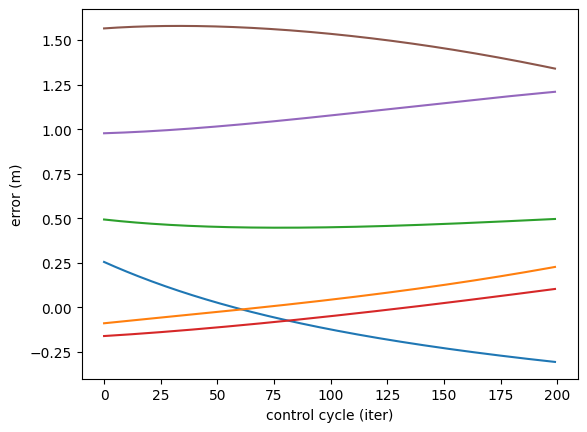

In [59]:
plt.plot(herr)
plt.xlabel('control cycle (iter)')
plt.ylabel('error (m)');

We can observe that each component of the error converges toward 0 following an exponential trajetory. The convergence is assymptotic. To fasten the convergence, increase the gain of the control law ($v_q = - \lambda J^+ e$), where the gain $\lambda$ has yet been set to 1.

### Place the end effector (6D)
The previous control law brings the center of the effector toward the center of the goal frame. However, it does not control the orientation of the end effector: the axes of the two frames F_tool and F_goal do not converge.
We should now modify the control law to take into account the tool orientation. For that, we compute the error to be the SE(3) log of the displacement from the tool frame F_tool to the goal frame F_goal.

We will use `J` instead of `J3`, and we need to compute  a vector of the generalized difference between the tool frame and the goal frame:
$$^{tool}M_{goal} = \vphantom{.}^{o}M_{tool} \vphantom{.}^{-1} \vphantom{.}^{o}M_{tool}$$
$$^{tool}w_{goal} = \vphantom{.}^{o}M_{tool} \ominus_{SE(3)} \vphantom{.}^{o}M_{tool} = log_{SE(3)}(^{tool}M_{goal})$$
where $^{tool}w_{goal}$ is a spatial vector in the local frame.

In [ ]:
toolMgoal = oMtool.inverse() * oMgoal
tool_w = pin.log(toolMgoal).vector

This error tool_nu is a 6d vector, that can be interpreted as the spatial (6d) velocity that should be applied during 1 second to displace the tool frame F_tool (placed at oMtool) to the goal frame F_goal (placed at oMgoal). This spatial velocity is expressed in the tool frame F_tool. It then corresponds to the 6D jacobian, that is also computed in the same frame F_tool.

Implement a second control law, following the same pattern than the previous control law. At each control cycle, you should:
* compute the displacement between F_tool and F_goal, denoted toolMgoal
* compute the 6D error using the SE(3) log tool_nu
* compute the 6D jacobian tool_Jtool
* compute the control law vq = pinv(J)*nu
* integrate the robot velocity vq during DT to get a new configuration q
* log the error by storing it in a list herr.

In [ ]:
# Your code

The tool frame F_tool converges toward the gooal frame F_goal: the center and the axes are finally aligned. The trajectory of the tool center is not a straight line, as the frame F_tool follows a "straight" line, not in R^3 but in SE(3).
We can also plot the error (assuming that herr is a list of the 6D errors herr).

In [ ]:
plt.subplot(211)
plt.plot([ e[:3] for e in herr])
plt.xlabel('control cycle (iter)')
plt.ylabel('error (m)')
plt.subplot(212)
plt.plot([ e[3:] for e in herr])
plt.xlabel('control cycle (iter)')
plt.ylabel('error (rad)');


### Inverse kinematics for two tasks
We yet controlled the robot with a single task (either the 3d position or the 6d placement errors). Let's see how to take into account a second task. Let's first introduce a second task. 

#### Introducing a second task: control the gaze
The robot has an additional frame named F_gaze, attached to the head and located 40 cm in front of the cameras. The task will be to position (3d) the center of this frame on an object of interest (a red ball).

In [ ]:
robot = loadTiago(addGazeFrame=True)
viz = MeshcatVisualizer(robot)

In [ ]:
IDX_GAZE = robot.model.getFrameId('framegaze')

# Add a small ball as a visual target to be reached by the robot
ball = np.array([ 1.2,0.5,1.1 ])
viz.addSphere('ball', .05, [ .8,.1,.5, .8] )
viz.applyConfiguration('ball', list(ball)+[0,0,0,1])

# Add the box again
oMgoal = pin.SE3(pin.Quaternion(-0.5, 0.58, -0.39, 0.52).normalized().matrix(),
                np.array([1.2, .4, .7]))
viz.addBox('goal', [.1,.1,.1], [ .1,.1,.5, .6] )
viz.applyConfiguration('goal',oMgoal)


In [ ]:
viz.display(q0)
viz.viewer.jupyter_cell()

Controlling this point can be done by achieving a simple variation of the control law for positioning (3d) the robot tool.

In [ ]:
# Your code

#### Performing 2 tasks

We now have two tasks (e1,J1) controlling the tool placement and (e2,J2) controlling the gaze position.

We use the previous technique to compute:
$$vq_1 = J_1^+ v_1^*$$
the optimal (in a least square sense) control for task 1. Then we can add any vector which is in the null space of $J_1$ to perform the second task. We search for $vq = vq_1 + dvq$ where $dvq$ gives an optimal control for task 2.

The orthogonal null space projector of $J_1$ can be computed using the pseudoinverse.
$$P_1 = I_{nq} - J_1^+ J_1$$
Finally, the control law to perform task 1 and task 2 in the null space of task 1 is:

$$vq_2 = vq_1 + (J_2 P_1)^+ ( v_2^* - J_2 vq_1)$$

You can now implement a control law solving the two tasks, i.e positioning the tool while controlling the gaze. Where we use $dvq$ being a solution of the minimisation problem:
$$\min_{x\in Ker(J_1)} \|J_2 (vq_1 + x) - v_2^*\|_2^2$$


In [ ]:
q = q0.copy()
herr = [] # Log the value of the error between tool and goal.
herr2 = [] # Log the value of the error between gaze and ball.
# Your code

In [ ]:
plt.subplot(311)
plt.plot([ e[:3] for e in herr])
plt.xlabel('control cycle (iter)')
plt.ylabel('error (m)')
plt.subplot(312)
plt.plot([ e[3:] for e in herr])
plt.xlabel('control cycle (iter)')
plt.ylabel('error (rad)');
plt.subplot(313)
plt.plot([ e for e in herr2])
plt.xlabel('control cycle (iter)')
plt.ylabel('error (rad)');


## Extension

A third task can be implemented as well by computing the null space of the two first tasks:

In [ ]:
Pgaze = Ptool - pinv(o_Jgaze3 @ Ptool) @ o_Jgaze3 @ Ptool


Load an extra cube in the viewer to figure a table. First control the robot hand to reach an arbitrary point on the table (don't mind for the collision). Then implement a control law to control three tasks:
* the tool frame should be kept on the table (i.e. only the z component of the error matter, select only the 3rd row of the matrix).
* the gaze should be control to reach the position of a ball object positionned on the table.
* the center of the basis frame should reach a given target on the floor. For this task, only the x- and y- component of the task matter, select only the 2 first rows.


In [ ]:
# Your code